In [1]:
# We import elementary libraries/modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

# Read the scores dataset and convert the column "scores" to float16
scores_df = pd.read_csv("./datasets/scores.csv")
scores_df["scores"] = np.float16(scores_df["scores"])

# Read the movies dataset to get the movie titles
platform_movies = pd.read_csv("./datasets/platform_movies_scores.csv")

# Set the format to our scores
reader = Reader(rating_scale=(1, 5))

# Load the data to be used to train our recommendation model.
data = Dataset.load_from_df(scores_df[['userId', 'movieId', 'scores']], reader)

# Split the dataset in trainset and testset
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

# Select a recommendation algorithm
model = SVD()

# Train the model with "trainset"
model.fit(trainset)

# Predict using the model and "testset"
predictions = model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)


RMSE: 1.0014


In [34]:
# In this part We will find the best parameters to optimize our model.
rmse_test_means = []
factors = [1,2,4,8,16,32,64,128]

for factor in factors:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9660  0.9658  0.9656  0.9658  0.0002  
Fit time          47.34   49.36   51.06   49.25   1.52    
Test time         35.45   34.77   35.37   35.20   0.31    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9669  0.9664  0.9662  0.9665  0.0003  
Fit time          47.51   49.95   51.81   49.75   1.76    
Test time         31.12   36.98   30.91   33.00   2.81    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9682  0.9681  0.9678  0.9680  0.0002  
Fit time          49.27   52.00   53.84   51.70   1.88    
Test time         34.38   33.91   34.34   34.21   0.21    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9708  0.9

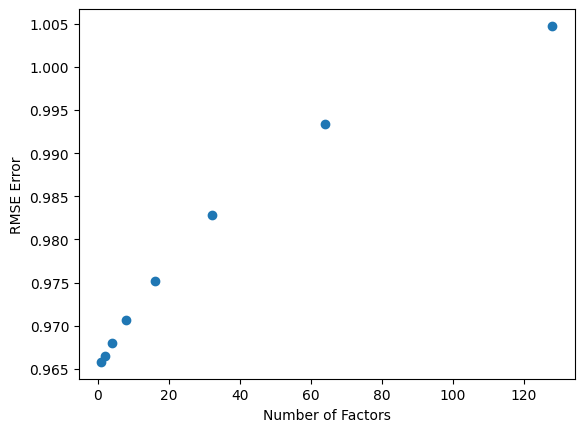

In [35]:
# Plot the perfomance based on the number of SVD factors
plt.scatter(factors, rmse_test_means)
plt.xlabel('Number of Factors')
plt.ylabel('RMSE Error')
plt.show()

In [3]:
# Function to Evaluate and predict if the movie is recommender for the user or not.
def evaluate_recommendation_movie(userId, movieId):
    
    # Get the title of the introduced movie
    movie_title = platform_movies[platform_movies.id == movieId].title.iloc[0].title()

    # Evaluate the movie using the model
    prediction = model.predict(userId,str(movieId))

    if prediction.est > 3.6:
        return "Of course, get some popcorn and enjoy", prediction.est, movie_title
    else:
        return "No, you will sleep in the middle", prediction.est, movie_title

In [21]:
# --------------
# Interface Part
# --------------

# Import Gradio Library
import gradio as gr
    
title = str("Movie Recommendation System")

with gr.Blocks(title= title) as demo:
    with gr.Row():
        with gr.Column(scale=0.5, min_width=600):
            userId = gr.inputs.Number(label="Introduce your User ID")
            movieId = gr.Textbox(label="Introduce your Movie ID")
            evaluate_recommendation_movie_btn = gr.Button("Evaluate if the movie is for you")
            movie_title = gr.Textbox(label = "Film:")
            output = gr.Textbox(label="Will I enjoy the movie?")
            score = gr.Textbox(label="Predicted Score:")
            evaluate_recommendation_movie_btn.click(fn=evaluate_recommendation_movie, inputs=[userId,movieId], outputs=[output, score, movie_title])

demo.launch(share = True)

c:\Users\snake\AppData\Local\Programs\Python\Python39\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
c:\Users\snake\AppData\Local\Programs\Python\Python39\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7870
Running on public URL: https://532e6241360838b50f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
